## Introduction
In the ever-evolving landscape of financial markets, the ability to gauge public sentiment swiftly and accurately has become a critical tool for investors and financial institutions. Public sentiment, reflected in news headlines, social media posts, and other forms of communication, is a powerful indicator of market trends and future stock prices. With the increasing volume of data generated daily, manually analyzing these sentiments is infeasible. This project aims to leverage natural language processing (NLP) techniques and deep learning models to automatically classify the sentiment of financial news headlines into positive, neutral, or negative categories. By automating this process, financial professionals can gain immediate insights into market sentiment, enabling them to make informed trading decisions and develop more effective investment strategies. 

This project aims to develop a deep-learning model that can accurately classify the sentiment of financial news headlines into positive, neutral, or negative classes. We will employ NLP techniques to preprocess the text data and build a deep-learning model to learn and infer sentiment from the headlines to address this challenge. The model's performance will be evaluated based on its accuracy in classifying the sentiment correctly.

## Data Source
The data is sourced from a 2013 study into Semantic Analysis of financial news; **Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts**. The dataset is comprised of 4840 English sentences, each assosciated with a label "positive", "neutral" or "negative". The dataset has no explicitly seperate test data, so in the model I will use a random selection of 80% of the data for training, 10% for testing and 10% for validation. Hence, the training dataset will comprise of 3872 data entries, and the test and validation sets will consist of 484 data entries each.

The dataset can be accessed [here](https://huggingface.co/datasets/takala/financial_phrasebank), and the paper from which the dataset originates can be accessed [here](https://arxiv.org/abs/1307.5336).

## Data Source Analysis
### Format of the data
Each data entry is comprised of two items, "sentence"; a tokenized line from the dataset and "labal"; a label denoting the class as a string 'positive', 'neutral' or 'negative'.

### Data Collection
Data was collected through scraping approximately 53000 sentences from English language news related to companies listed in OMX Helsinki. The data was taken from the LexisNexis database. A sample of 5000 entries was then taken to create the dataset. A mix of 16 researchers and Master's students at Aalto University School of Business were screened for appropriate knowledge and selected to label the data. Each annotater spent one month labelling a random subset of the data as one of the three classes. On average, each annotator labelled 1500 sentences. The label for each sentence present in the dataset was chosen through a majority vote of up to 12 annotators.

### Data Splits
It should be considered that while the dataset uses a majority vote to determine the label of each sentence, there was significant disagreement between annotators on how specific entries should be labelled. This was especially prevalent in entries that could be considered either 'positive' or 'neutral'. To account for this, the authors of this dataset split the data into 4 subsets as follows;
| Subset | Num Entries |
|---|---|
| Sentences with 100% agreement | 2259 |
| Sentences with > 75% agreement | 3448 |
| Sentences with > 66% agreement | 4211 |
| Sentences with > 50% agreement | 4840 |

In my report, I use the full dataset to try and emulate a real world scenario.

### Challenging Aspects
There are a number of challenging aspects in constructing a model to classify the data.

One of the most difficult aspects will be to seperate true and false positive sentences. This is especially prevalent in financial news, where companies will often use high modality, positive words to describe average or normal performance. This is a problem present in the training data as well. While annotators were often in agreement over classifications of positive against negative, and negative against neutral, respondents were much more divided over positive against neutral data. A sampling of 150 sentences labelled by all anotators reveal the average Positive vs. Neutral pairwise agreement between annotators was only 75.2%. This will be a significant hurdle for our model to overcome.

Another challenging aspect is the limited size of the dataset. 5000 entries will be sufficient to train the model, but in comparison to major modern machine learning projects, this is a limited number of entries. This is especially a concern for more contested sentences, with between 50% and 66% annotator agreeement, of which only 600 exist. After removing 20% of the entries for validation, this subset will contain less than 500 training items.

Another problem is a major imbalance in the distribution of the labels in the dataset. Below are the number of data items seperated by label;
| Label | Num Items|
|---|---|
| Positive | 1363 |
| Neutral | 2879 |
| Negative | 604 |

The dataset heavily features neutral examples over positive and especially negative ones. This can make training generalised models diffiuclt, and also cause misleading results to appear, as demonstrated by the VADER model later in the report.

### Preprocessing

To process the dataset for use in the models, the items are first read for a file and split to seperate the label from the sentence. The sentences are then tokenized, and the labels encoded.

In [1]:
import numpy as np
from string import punctuation

In [ ]:
f = open("FinancialPhraseBank-v1.0/Sentences_50Agree.txt", "r", encoding='latin-1')
sentences = []
labels = []
all_words = []
sentence_length = 0
content=f.readline()
while content != "":
    content = content.split("@")

    # Create array of labels
    content[1] = content[1].rstrip('\n')
    labels.append(content[1])

    # Create array of sentences
    content[0] = ''.join([c for c in content[0].lower() if c not in punctuation])
    sentences.append(content[0])
    content[0] = content[0].split()

    # Get longest sentence so I can pad the other accordingly
    if len(content[0]) > sentence_length: sentence_length = len(content[0])

    # Make an array with all the words to construct a dictionary
    for word in content[0]:
        all_words.append(word)

    content=f.readline()

In [3]:
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(all_words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
sentences_ints = []
for s in sentences:
  sentences_ints.append([vocab_to_int[word] for word in s.split()])

print('Unique words: ', len((vocab_to_int)))

print('Sample sentence: \n', sentences[:1])
print('Tokenized sentence: \n', sentences_ints[:1])

Unique words:  11258
Sample sentence: 
 ['according to gran  the company has no plans to move all production to russia  although that is where the company is growing ']
Tokenized sentence: 
 [[79, 5, 3549, 1, 12, 16, 220, 301, 5, 618, 111, 73, 5, 127, 2799, 28, 10, 390, 1, 12, 10, 707]]


In [4]:
# 0=negative, 1=neutral, 2=positive label conversion
encoded_labels = np.array([0 if label == 'negative' else 1 if label == 'neutral' else 2 for label in labels])

All entries are padded with leading zeroes to match the length of the longest sentence, 52 words.

In [5]:
def pad_features(tokens, seq_length):
    ''' Return features of sentence_ints, where each sentence is padded with 0's
    '''
    ## getting the correct rows x cols shape
    features = np.zeros((len(tokens), seq_length), dtype=int)

    ## for each review, I grab that review
    for i, row in enumerate(tokens):
      features[i, -len(row):] = np.array(row)[:seq_length]

    return features

features = pad_features(sentences_ints, sentence_length)
print('Sentence length:', sentence_length)
print(features[:3])

Sentence length: 52
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   79    5 3549    1   12   16  220  301    5  618  111   73
     5  127 2799   28   10  390    1   12   10  707]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0  792  301    5  833    3
  1779   33  172    2  220 1140   91 1780  650 1781    3  108    5 3550
    82  751    3 1232  538    4  708    1  881   20]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    1  261  619  126   12  302   16 1233  348
  3551    2  144   13   15 1141  254 5195    5  130  539    1   12 2327
     1 5196    2   15  239  929    1  834 5197  221]]


In order to ensure training and evaluation are consistent, the data is reordered before being split into training, validation and test sets. This ensures a comaparable proportion of negative, neutral, and positive examples across the three sets. Without this reordering, generated test sets were prone to be poor evaluators of models. Initially, for instance, the models were trained on just 100 negative examples, but tested on over 300, leading to poor accuracy.

In [6]:
class_nums = [0,0,0]
for label in encoded_labels:
    class_nums[label] += 1
print('Number of data items seperated by class:', class_nums)

Number of data items seperated by class: [604, 2879, 1363]


In [7]:
data_by_class = [[],[],[]]

for i in range(len(encoded_labels)):
    data_by_class[encoded_labels[i]].append(features[i])

In [8]:
even_features = []
even_labels = []

# Get proportions
proportions = [0, 0, 0]

for i in range(3):
    proportions[i] = round(len(features)/len(data_by_class[i]))

proportions[0] += 1

i = 0
while len(even_features) != len(features):
    for j in range(3):
        if (i % proportions[j] == 0 and len(data_by_class[j]) > 0):
            even_features.append(data_by_class[j].pop(0))
            even_labels.append(j)
    i += 1

print(f'Step {i}: Classified: {len(even_features)} features, {len(even_labels)} labels')

Step 5757: Classified: 4846 features, 4846 labels


In [9]:
features = np.array(even_features)
encoded_labels = np.array(even_labels)

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeatures Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Features Shapes:
Train set: 		(3876, 52) 
Validation set: 	(485, 52) 
Test set: 		(485, 52)


The 80:10:10 ratio of data sets was chosen to maximise training data. Conversely, the batch size of 50 was chosen empirically by testing smaller and greater sizes.

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [11]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 52])
Sample input: 
 tensor([[   0,    0,    0,  ...,   14, 6154,   51],
        [   0,    0,    0,  ...,   54,    3, 1442],
        [   0,    0,    0,  ..., 3793,    2, 4067],
        ...,
        [   0,    0,    0,  ...,   91, 2263,   82],
        [   0,    0,    0,  ..., 4192,    4, 6673],
        [   0,    0,    0,  ...,    4, 6969,  159]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1,
        2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 1])


# Data Augmentation section

Records an attempt to increase sample size of data for test results. Successful in increasing set size by 20,000 cases. However, manual examination of data revealed the unreliability of augmented data.

E.g. Synonyms not preserving the sentiment adequately. One example is below

- Original: This is an example sentence for data augmentation
- Synonym Augmentation: This is an example prison term for data point augmentation.
- Random Insertion Augmentaton: information This is an good example example sentence for data augmentation
- Random Deletion augmentation: is an sentence for data
- Random Swap: an is for example sentence This data augmentation.
- Back Translaton: This is an example of a sentence for the increase in data.

As seen, not suitable for use, didn't drastically improve test output, likely to maybe worsen applicability of model

In [6]:
import random
import nltk
from nltk.corpus import wordnet, stopwords
from googletrans import Translator

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').replace('-', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    sentence = ' '.join(new_words)
    return sentence

# Example usage
sentence = "This is an example sentence for data augmentation."
augmented_sentence = synonym_replacement(sentence, n=2)
print(augmented_sentence)

This is an example condemnation for information augmentation.


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


In [7]:
def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        add_word(words)
    return ' '.join(words)

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[random.randint(0, len(synonyms)-1)]
    random_idx = random.randint(0, len(words)-1)
    words.insert(random_idx, random_synonym)

# Example usage
augmented_sentence = random_insertion(sentence, n=2)
print(augmented_sentence)

This is an example sentence for comprise datum data augmentation.


In [8]:
def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:
        return sentence

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        return random.choice(words)
    
    return ' '.join(new_words)

# Example usage
augmented_sentence = random_deletion(sentence, p=0.3)
print(augmented_sentence)

This an example data augmentation.


In [9]:
def random_swap(sentence, n):
    words = sentence.split()
    for _ in range(n):
        words = swap_word(words)
    return ' '.join(words)

def swap_word(words):
    random_idx_1 = random.randint(0, len(words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(words)-1)
        counter += 1
        if counter > 3:
            return words
    words[random_idx_1], words[random_idx_2] = words[random_idx_2], words[random_idx_1]
    return words

# Example usage
augmented_sentence = random_swap(sentence, n=2)
print(augmented_sentence)

sentence is This example an for data augmentation.


In [10]:
def back_translation(sentence, src='en', mid='fr'):
    translator = Translator()
    translated = translator.translate(sentence, src=src, dest=mid).text
    back_translated = translator.translate(translated, src=mid, dest=src).text
    return back_translated

# Example usage
augmented_sentence = back_translation(sentence)
print(augmented_sentence)

This is an example of a sentence for the increase in data.


## VADER
As part of the investigation into the efficacy of various models, I examined the pretrained model Valence Aware Dictionary and sEntiment Reasoner (VADER). Vader uses a lexicon of sentiment-related words to determine the overall sentiment of a given body of text, built by crowdsourcing labelling to strangers using Amazon’s Mechanical Turk. Vader outputs the probability of a given sentence falling into the classes positive, neutral and negative. We take the highest likelihood output as the model's selection.

In [185]:
import nltk

nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/oscarparrish/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [186]:
estimated_class = []
probs = []
classes = ['negative', 'neutral', 'positive']
for sentence in sentences:
    current_score = analyzer.polarity_scores(sentence)
    probability = list(current_score.values())[:3]
    probs.append(current_score)
    estimated_class.append(probability.index(max(probability)))

total_entries = len(encoded_labels)
misclassifications = [0, 0, 0]
classifications = [0, 0, 0]
num_correct = 0
for i in range(total_entries):
    if (estimated_class[i] == encoded_labels[i]):
        num_correct += 1
        classifications[estimated_class[i]] += 1
    else:
        misclassifications[estimated_class[i]] += 1

accuracy = num_correct/total_entries

print(f'Correct Classifications: {classifications}')
print(f'Misclassifications: {misclassifications}')
print(f'Final Accuracy: {"{:.2f}".format(accuracy)}')

Correct Classifications: [0, 2873, 5]
Misclassifications: [0, 1957, 11]
Final Accuracy: 0.59


## TextCNN Model with PyTorch
TextCNN, or Convolutional Neural Networks for text classification, is a powerful and efficient model introduced by Yoon Kim in his 2014 paper "Convolutional Neural Networks for Sentence Classification". TextCNN leverages the principles of CNNs, commonly used in image processing, to capture local features in text data. It is especially effective for tasks like sentiment analysis, where identifying key phrases or n-grams is crucial.

**Key Components**
1. Embedding Layer: Converts input text into dense vectors that represent words in a continuous vector space, capturing semantic relationships.
2. Convolutional Layers: Apply convolution operations to the embeddings to extract features. Different filters (kernels) of varying sizes (e.g., 2, 3, 4 words) slide over the embeddings, capturing different n-grams.
3. Activation Function: Typically, the ReLU (Rectified Linear Unit) activation function is used to introduce non-linearity.
4. Max-Pooling Layer: After convolution, max-pooling is applied to down-sample the feature maps, capturing the most important features and reducing dimensionality.
5. Fully Connected Layer: The pooled features are flattened and passed through one or more fully connected layers for final classification.

In [85]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [86]:
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes 
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # (batch_size, 1, seq_length, embed_dim)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(batch_size, num_filters, *)] * len(kernel_sizes)
        x = [F.max_pool1d(item, item.size(2)).squeeze(2) for item in x]  # [(batch_size, num_filters)] * len(kernel_sizes)
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [87]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1  # Plus 1 for padding index 0
embed_dim = 100
num_classes = 3  # Positive, Neutral, Negative
kernel_sizes = [3, 4, 5]
num_filters = 100

# Initialize model
model = TextCNN(vocab_size, embed_dim, num_classes, kernel_sizes, num_filters)

# Print model architecture
print(model)

TextCNN(
  (embedding): Embedding(11259, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=3, bias=True)
)


In [88]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [89]:
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training function
def train(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    model.train()

        
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(correct_train/total_train)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.long())
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(correct_valid/total_valid)

        print(f"Epoch {epoch+1}/{epochs} "
            f"Train Loss: {train_losses[-1]:.3f} "
            f"Train Accuracy: {train_accuracies[-1]:.3f} "
            f"Valid Loss: {valid_losses[-1]:.3f} "
            f"Valid Accuracy: {valid_accuracies[-1]:.3f}")
        
# Train the model
train(model, train_loader, valid_loader, criterion, optimizer, epochs=10)

Epoch 1/10 Train Loss: 0.936 Train Accuracy: 0.582 Valid Loss: 0.812 Valid Accuracy: 0.608
Epoch 2/10 Train Loss: 0.637 Train Accuracy: 0.739 Valid Loss: 0.747 Valid Accuracy: 0.668
Epoch 3/10 Train Loss: 0.440 Train Accuracy: 0.854 Valid Loss: 0.751 Valid Accuracy: 0.676
Epoch 4/10 Train Loss: 0.263 Train Accuracy: 0.938 Valid Loss: 0.811 Valid Accuracy: 0.682
Epoch 5/10 Train Loss: 0.137 Train Accuracy: 0.988 Valid Loss: 0.763 Valid Accuracy: 0.697
Epoch 6/10 Train Loss: 0.070 Train Accuracy: 0.997 Valid Loss: 0.783 Valid Accuracy: 0.697
Epoch 7/10 Train Loss: 0.043 Train Accuracy: 0.998 Valid Loss: 0.786 Valid Accuracy: 0.697
Epoch 8/10 Train Loss: 0.032 Train Accuracy: 0.998 Valid Loss: 0.840 Valid Accuracy: 0.701
Epoch 9/10 Train Loss: 0.026 Train Accuracy: 0.999 Valid Loss: 0.854 Valid Accuracy: 0.707
Epoch 10/10 Train Loss: 0.023 Train Accuracy: 0.999 Valid Loss: 0.861 Valid Accuracy: 0.713


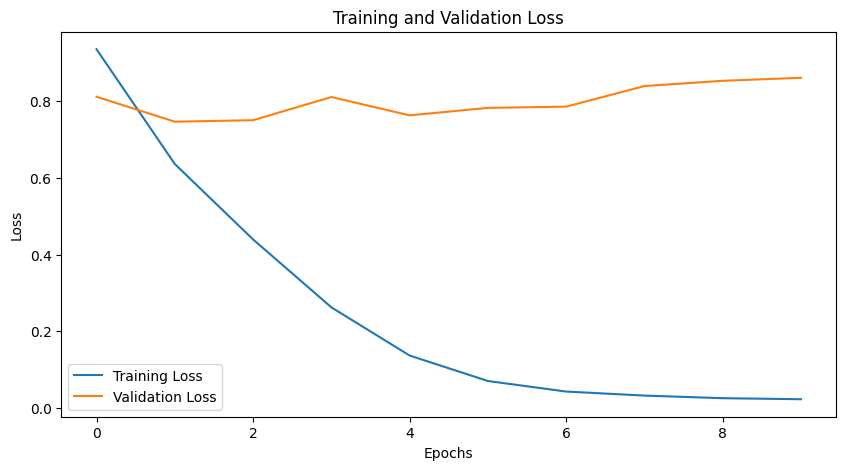

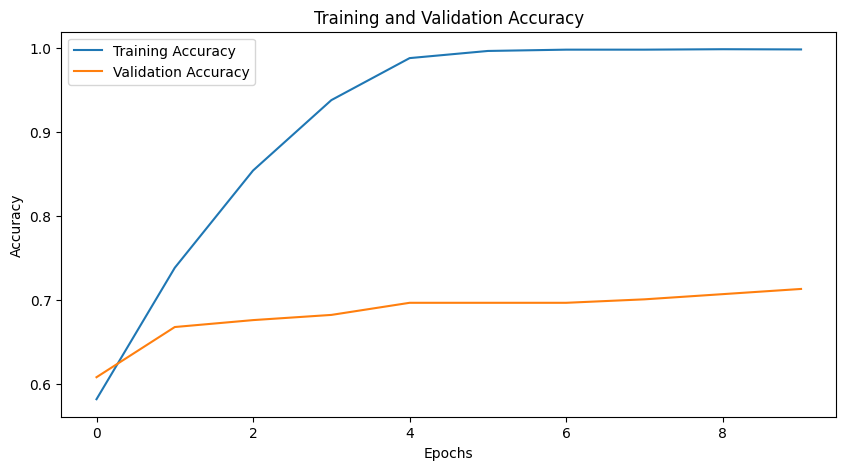

In [90]:
# Plot the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [91]:
# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    all_inputs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            test_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Loss: {test_loss/len(test_loader):.3f} Test Accuracy: {accuracy:.3f}")

# Evaluate the model
evaluate(model, test_loader, criterion)

Test Loss: 0.731 Test Accuracy: 0.765


# LSTM Model

LSTM implementedi n tensflow is based of a RNN desigend to handle sequential data and retain long-term depednencies. LSTMS in the usecase are particularly effective in sentiment analysis hypothetically due to their ability to remember important information over extended sequences and omit (forget) irrelevant data. They are improvements on a traditional RNN as LSSTM use memory cells and gates (input, forget and output gates) to regulate the flow of information, making tehm adept at capturing the context and dependencies in textual data.

Key features
- Embeddings - converts input text into dense vectors to attempt to capture semantic relationships. 
- LSTM layers - core component of the model, the LSTM cell contins memory cells and gates to control information flow, allowing importnat context to be captured over many steps
- SpatialDropout1D and Dropout - regularisation technqiues where random nodes are deactivted duing training. Helps prevent overfitting and supposedly improves model generaliszation. SpatialDropout1D is applied to the embedding layer to drop entire 1D feature maps, while Dropout is applied after the LSTM layers.
- Output layer - final layer has 3 nodes predict a class (pos, neg, neutral)
- Softamx - used in output layer to ensure total output capped at 1.

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Build the LSTM model
resize = 1
vocab_size = len(vocab_to_int) + 1
embedding_dim = int(100 * resize)
lstm_units = int(128 * resize)
dropout = 0.5
l2_lambda = 0.01
dropout_rate = 0.5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sentence_length),
    tf.keras.layers.SpatialDropout1D(dropout),
    tf.keras.layers.LSTM(lstm_units, return_sequences=True),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.LSTM(lstm_units),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Train the model
batch_size = 32
epochs = 10

history = model.fit(train_x, train_y, epochs=epochs, validation_data=(val_x, val_y), batch_size=batch_size)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5734 - loss: 0.9323 - val_accuracy: 0.6247 - val_loss: 0.7604
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7234 - loss: 0.6413 - val_accuracy: 0.6825 - val_loss: 0.7555
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8697 - loss: 0.3506 - val_accuracy: 0.6969 - val_loss: 0.8337
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9289 - loss: 0.2079 - val_accuracy: 0.7175 - val_loss: 0.8426
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9525 - loss: 0.1348 - val_accuracy: 0.6763 - val_loss: 1.2115
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9723 - loss: 0.0847 - val_accuracy: 0.6701 - val_loss: 1.1613
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9772 - loss: 0.0761 - val_accuracy: 0.6680 - val_loss: 1.2237
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9813 - loss: 0.0598 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6855 - loss: 1.5202
Test Accuracy: 0.67


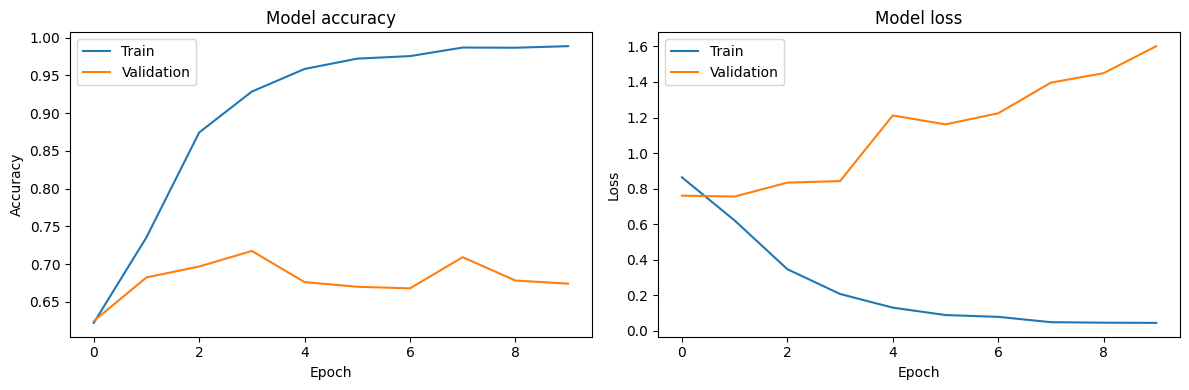

In [26]:
# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
      Class  Correct Labels  Incorrect Labels
0  Positive              30                11
1   Neutral             250                97
2  Negative              45                52


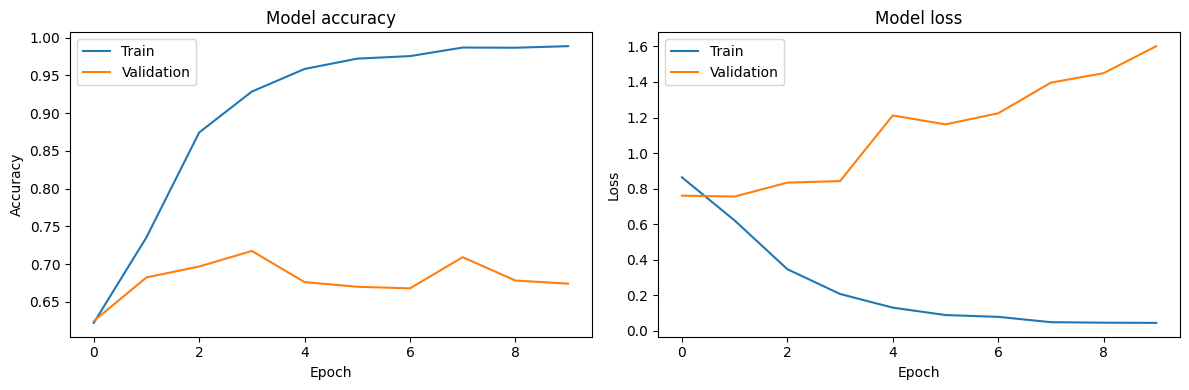

In [29]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Get model predictions
predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)

# Get confusion matrix
conf_matrix = confusion_matrix(test_y, predicted_labels)

# Calculate correct and incorrect labels for each class
classes = ['Positive', 'Neutral', 'Negative']
correct_labels = np.diag(conf_matrix)
incorrect_labels = np.sum(conf_matrix, axis=1) - correct_labels

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Class': classes,
    'Correct Labels': correct_labels,
    'Incorrect Labels': incorrect_labels
})

# Display the table
print(results_df)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Bi-Directional Gated Recurrent Unit
A Bi-Directional Gated Recurrent Unit (Bi-GRU) is an extension of GRU. GRUs, like LSTM, are a recurrent neural network that uses a reset, update and forget gate to transform input vectors to output vectors. Unlike LSTM, which receives as input a hidden and cell state from a previous unit, as well as an input, GRU doesn't use a cell state. This simplifies the architecture, and makes it faster to compute. In the Bi-GRU architecture, each hidden layer input is a combination of both the previous and next unit's hidden layer output. In this way, Bi-GRU can account for context as a combination of future and past words, as opposed to just passed words as in GRU. This makes the model more successful at sentiment analysis as it can more accurately account for context.

Key Features:
1. Embedding: Converts input text into dense vectors that represent words in a continuous vector space, in order to capture semantic relationships.
2. Dropout: Each time the model trains, random nodes are deactivated. This helps to prevent overfitting by forcing the model to produce a generalised solution that can correctly classify data even when some points are missing.
3. Hidden Layer: The 256 nodes of the embedding are densely connected to 128 nodes to extract semantic and contextually important features.
4. ReLU: The Rectified Linear Unit activation function is by far the most popular and empirically successful activation function in relating nodes within a neural network.
5. Output Layer: THe 128 nodes of the embedding are connected to 3 output nodes which give a probability distribution for the expected class.
6. SoftMax: The SoftMax activation function emulates a sigmoid but interacts with other nodes to ensure the total output is capped to 1, giving a probability distribution over the three classes.

In [13]:
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, bidirectional=True):
        super(BiGRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.dropout1D = nn.Dropout1d()
        self.dense = nn.Linear(hidden_size * 2, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout1D(x)
        gru_out, _ = self.gru(x)
        gru_out = gru_out[:, -1, :]
        x = self.dense(gru_out)
        nn.ReLU(x)
        x = self.fc(x)
        nn.Softmax(x)
        return x

In [14]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
embed_size = 64
hidden_size = 128
output_size = 3
num_layers = 2
bidirectional = True
learning_rate = 0.001
num_epochs = 10

model = BiGRUClassifier(vocab_size, embed_size, hidden_size, output_size, num_layers, bidirectional)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/10], Train Loss: 0.9190, Validation Loss: 0.8921, Validation Accuracy: 58.14%
Epoch [2/10], Train Loss: 0.8550, Validation Loss: 0.8366, Validation Accuracy: 62.27%
Epoch [3/10], Train Loss: 0.8078, Validation Loss: 0.8187, Validation Accuracy: 61.86%
Epoch [4/10], Train Loss: 0.7501, Validation Loss: 0.8522, Validation Accuracy: 61.44%
Epoch [5/10], Train Loss: 0.6918, Validation Loss: 0.8188, Validation Accuracy: 63.71%
Epoch [6/10], Train Loss: 0.6434, Validation Loss: 0.7700, Validation Accuracy: 65.98%
Epoch [7/10], Train Loss: 0.5783, Validation Loss: 0.7322, Validation Accuracy: 66.39%
Epoch [8/10], Train Loss: 0.5297, Validation Loss: 0.8464, Validation Accuracy: 65.57%
Epoch [9/10], Train Loss: 0.5012, Validation Loss: 0.8383, Validation Accuracy: 65.77%
Epoch [10/10], Train Loss: 0.4476, Validation Loss: 0.8103, Validation Accuracy: 65.57%


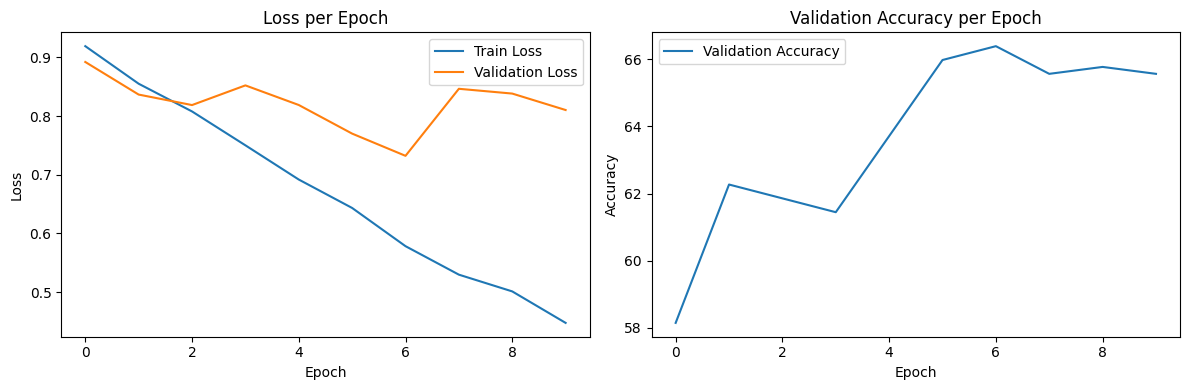

In [15]:
# Lists to store loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        sequences, labels = batch
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in valid_loader:
            sequences, labels = batch
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(valid_loader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(valid_loader):.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Evaluation

misclassifications = [0,0,0]
classifications = [0,0,0]

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        sequences, labels = batch
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(sequences)):
            if (predicted[i] == labels[i]): classifications[predicted[i]] += 1
            else: misclassifications[predicted[i]] += 1

    print(f'Correct classifications: {classifications}')
    print(f'Misclassifications: {misclassifications}')
    print(f'Accuracy: {100 * correct / total:.2f}%')

Correct classifications: [15, 261, 48]
Misclassifications: [36, 55, 70]
Accuracy: 66.80%


### BERT model in PyTorch

BERT is a transformer-based model that reads text in both directions to understand context. It is used for tasks like text classification, question answering, and named entity recognition. 

In BERT, embeddings are crucial for processing and understanding the input text. BERT uses three types of embeddings:

Token Embeddings: These embeddings represent individual tokens (words or subwords) in the input text.

Positional Embeddings: Since transformers do not inherently understand the order of tokens, positional embeddings encode the position of each token in the sequence.
		       These embeddings allow the model to take into account the order of words, which is essential for understanding the context.

Segment (Token Type) Embeddings: For tasks involving pairs of sentences (e.g., next sentence prediction), segment embeddings distinguish between different sentences.
				 Tokens from the first sentence are assigned one type of embedding (usually all zeros), and tokens from the second sentence are assigned another type (usually all ones).

To construct this model lets download and import the needed libraries 

In [18]:
# Import necessary libraries
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
from torch import nn, optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset

# Misc.
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'

%pip install transformers
%pip install seaborn

import transformers
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# Loading model and adjusting hyper paramters 

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # Number of sentiment labels
)
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
total_steps = len(train_loader) * epochs

# Set up learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Set up device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [20]:
# Compute class weights

class_counts = np.bincount(encoded_labels)
total_count = len(encoded_labels)
class_weights = [total_count / (len(class_counts) * count) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [21]:
# Training function

def train(model, dataloader, optimizer, scheduler, class_weights):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Define the loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)


    for batch in dataloader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device).long()  # Convert labels to LongTensor

        optimizer.zero_grad()

        outputs = model(input_ids=b_input_ids, labels=b_labels)
        loss = criterion(outputs.logits, b_labels)  # Use the logits for the loss function
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == b_labels)
        total_predictions += b_labels.size(0)

    accuracy = (correct_predictions.double() / total_predictions).item() * 100
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, accuracy

In [22]:
# Evaluate function

def evaluate(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_labels = b_labels.to(device).long()  # Convert labels to LongTensor

            outputs = model(input_ids=b_input_ids)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.tolist())
            true_labels.extend(b_labels.tolist())

    accuracy = accuracy_score(true_labels, predictions) * 100
    return predictions, true_labels, accuracy

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/3
Training loss: 1.0979
Training Accuracy: 37.87%
Validation Accuracy: 29.07%
Epoch 2/3
Training loss: 1.0883
Training Accuracy: 33.51%
Validation Accuracy: 58.35%
Epoch 3/3
Training loss: 1.0843
Training Accuracy: 37.28%
Validation Accuracy: 12.99%
Test Accuracy: 8.45%


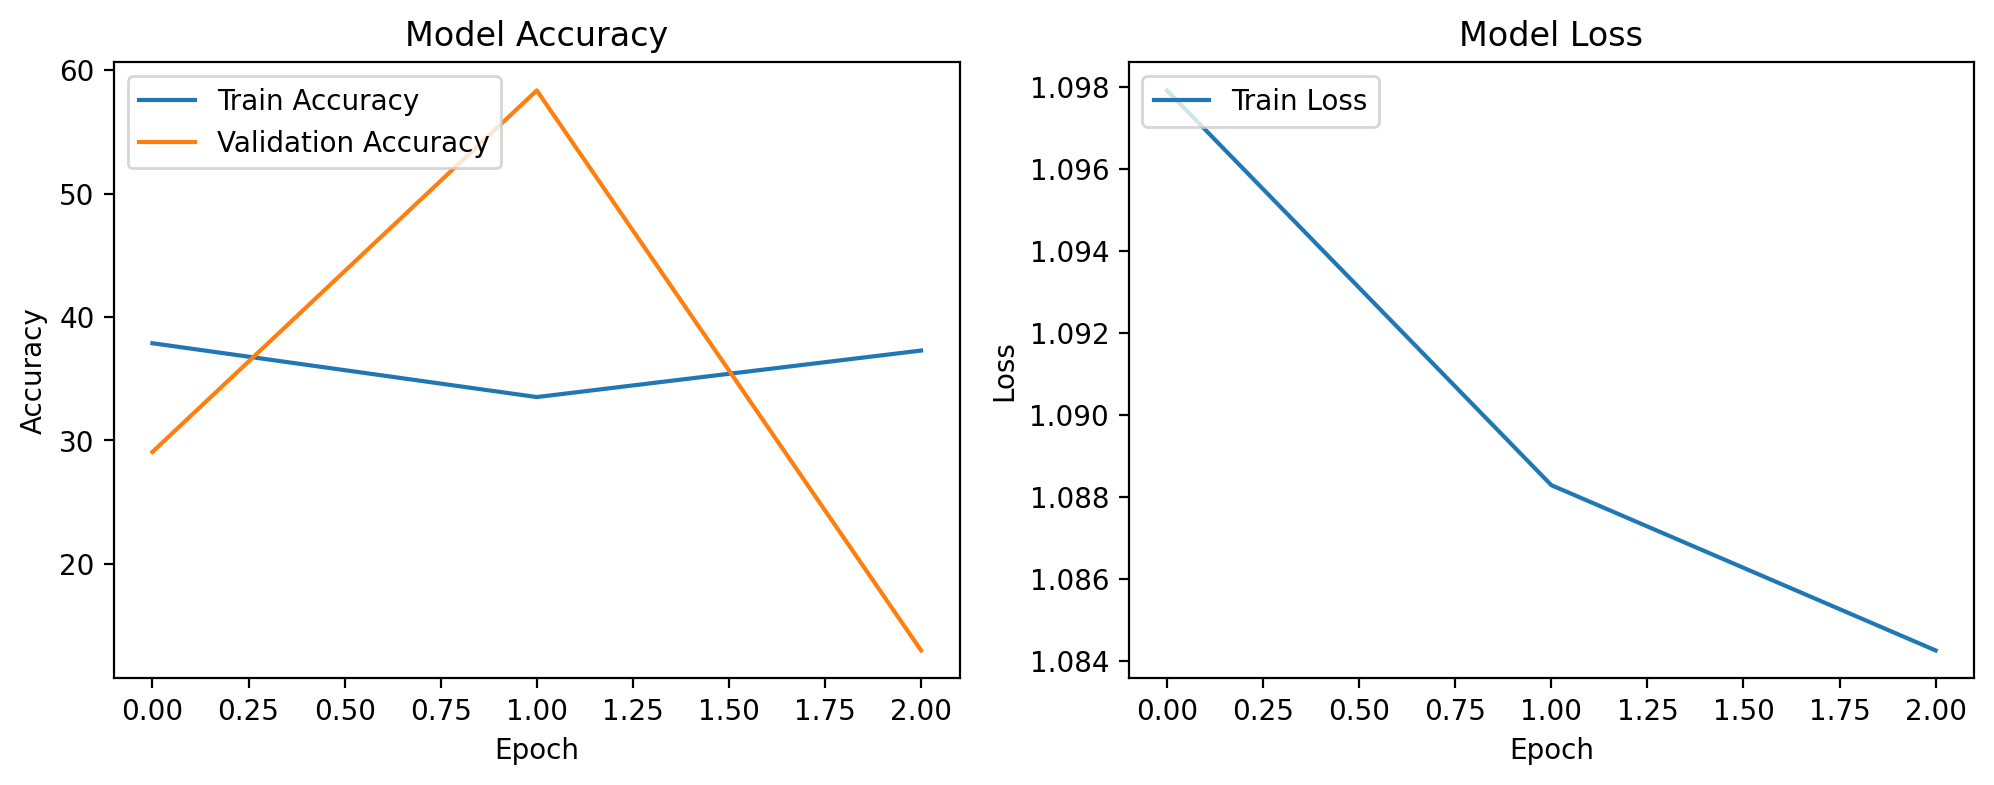

In [23]:
# Plotting training and validation accuracy 

# Lists to store metrics
train_loss_values = []
train_accuracy_values = []
val_accuracy_values = []
total = 0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Train the model
    train_loss, train_accuracy  = train(model, train_loader, optimizer, scheduler, class_weights)
    print(f"Training loss: {train_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    
    # Store training metrics
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    # Evaluate the model on the validation set
    predictions, true_labels, val_accuracy = evaluate(model, valid_loader)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # Store validation metrics
    val_accuracy_values.append(val_accuracy)

# Evaluate the model on the test set after training is complete
test_predictions, test_true_labels, test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_values, label='Train Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# RESULTS

## VADER
VADER initially appears to have performed moderately well, with a final accuracy of 59%. However, examining the output of the model it is clear that the model classified 4830 out of 4846 items as "neutral". Hence, this accuracy score is more reflective of the misbalanced labellings of the dataset than a true generalised model. The full output of VADER was:

| Class | Correct Classifications | Misclassifications |
|---|---|---|
| Positive | 5 | 11 |
| Neutral | 2873 | 1957 |
| Negative | 0 | 0 |

A possible reason for this output is the way VADER was trained. VADER was trained largely on sentences taken from social media, as such it places high semantic value on things like emojis and words written in full capital letters. Comparitively, the dataset used in this project comprises largely of dry, formal language, with lots of filler words. Because VADER was trained on such high modality language, it struggles to perceive the subtleties of language in this dataset, and overwhelming classes it as neutral.

## Text CNN
TextCNN model manage to achieve a final accuracy of 76.5%. This suggests that the model manage to perform quite well in the task of classifying sentiment in text. While these results are promising, it may still require to be much more efficient for real-world application. The strength of TextCNN is in its simplistic training and implementation, which allows faster training times and faster deployment. This also allows the model to perform realtively well with a small dataset compared to the other models.
Despite the strengths, TextCNN still struggles with capturing long-range dependencies and context, which are better handled by the other models like BERT, LSTM and GRU. These models tend to understand context over long sequences, which is often crucial for finance sentiment analysis. Certain improvements could be made to this model that would help with minimizing its weaknesses, such as combining CNNs with RNNs or transformers to leverage the strengths of both architectures, capturing local patterns and long-range dependencies.

## LSTM
The LSTM model achieved a test accuracy of 67.0%, slightly higher than the Bi-GRU model. This indicates a marginally better performance in classifying the data. However, the an analysis of the classifications and misclassifications reveals areas for improvement, especially for neutral examples. Was a bit better at positve examples, however a more accurate a balanced model would likely be achieved with more data.

| Class | Correct Classifications | Misclassifications |
|---|---|---|
| Positive | 30 | 11 |
| Neutral | 250 | 97 |
| Negative | 45 | 52 |

## Bi-GRU
Bi-GRU was reasonably successful at classifying the data, giving a final accuracy of 66.8%. Looking at the classifications and misclassifications output by the model, we find a reasonably even spread of results, indicative of a generalised model. However, it's still clear that the saturation of neutral training examples has skewed the model. Of the 316 times the model output a neutral response, only 17.4% of them were incorrect. Alternatively, nearly a third of positive classifications and more than half of negative classifications were eroneous. This labelling data is below:

| Class | Correct Classifications | Misclassifications |
|---|---|---|
| Positive | 48 | 70 |
| Neutral | 261 | 55 |
| Negative | 15 | 36 |

## BERT
The BERT model did not achieve the intended accuracy, giving a test accuracy of 8.45%. This could be attributed to a range of things however the main factors involve the quality of data and the quantity of data.

| Class | Correct Classifications | Misclassifications |
|---|---|---|
| Positive | 10 | 108 | 
| Neutral | 45 | 271 | 
| Negative | 7 | 44 |

The high content of nuetral labels did not help interm of learning the difference of classes.
As we can see the the model is not able I differentiate between the classes. This is possibly from the lack of data causing the inability for the model to learn aswell as the skew of data majoring nuetral contributing to the lack of learning. 


## Combined Results and Discussion
By comparing the output of multiple models, it is clear that under these conditions TextCNN performs the best. This is a somewhat unexpected outcome, as many of the available academic papers on the subject of natural language processing indicate BERT as the most successful model. This report argues that BERT was kneecapped in this particular scenario by the lack of available training data. Natural Language Processing models are most effective when given significant amounts of training data, as semantic and contextual patterns become more apparent. BERT specifically is designed to learn the contextual connections between words, and likely struggled with such a small dataset. Comparitively, the relatively simpler models TextCNN and Bi-GRU thrived, as they could more quickly determine and mark individual words with high semantic value.

In regards to performance, TextCNN, Bi-GRU and LSTM are all light weight models that can be trained quickly and classify test data fast. This is owed in part to the small vocabulary of 11258 unique words and the relatively short sentences. The longest sentence present in the dataset was 52 words, and all others were padded with leading zeroes to match. Conversely, BERT, with it's 110 million trainable parameters, is computationally expensive, especially when without access to a GPU.

Below is the table of models in this report scored by accuracy. Note that the accuracy of VADER in particular should not be taken as a measure of it's success, for reasons explored in the VADER Results section above

|Model|Accuracy|
|---|---|
|TextCNN|76.5%|
|LSTM|67.0%|
|Bi-GRU|66.8%|
|VADER|59.0%*|
|BERT|8.5%|

### Effectiveness of Selected Model
With an accuracy of 76.5%, we believe the TextCNN model would be effective in a real world scenario. The model was intentionally trained on the "greater than 50% agreement" data split in order to expose it to as much contentious, real world data as possible. The model we've developed is highly specialised for it's domain, and far surpasses general use models like VADER. When comparing it to the results achieved in "**Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts**", which uses the same dataset, we find TextCNN falls short of the 85.8% achieved by the team, approximately a 10% drop in efficacy, possibly resulting from the simpler architecture of TextCNN. However, we still believe that the model is accurate enough to be useful in long term classifications and trend analysis in the financial space.

### Future Research Paths
There are a number of paths that we undertook to improve the performance of the model but through difficulty or time constraints were unable to complete. These would be excellent avenues for future research.

The first technique examined was the possiblity of augmenting pre-existing data items to generate new 'virtual' data items that would still be semantically consistent. We significantly explored this technique, and the code used to generate the virtual items can be found further up this notebook. Our technique involved replacing arbitrary words in sentences with synonyms pulled from a thesaurus dataset. For instance, the sentence fragment "This is great!" might be used to generate the new virtual sentence fragment "This is amazing!". In this way, a new data item has been generated with the same semantic label of "positive". However, in practice we found the synonym replacement was overzealous. In one particular instance it replaced the sentence fragment "... this sentence is..." with the fragment "...this condemn is...". While condemn is a valid synonym for sentence, the programs lack of contextual understanding has created an incorrect sentence. With further work, this technique could produce useable results, but due to time constraints it was unfortunately shelved.

Another technique for future research is ensembling. As the project consists of a number of varying models, ensembling all or some of the models has promise in producing more accurate results. However, owing to the extreme variance in accuracy between models, we reached the conclusion that we couldn't guarantee the effectiveness of an ensembled approach. This technique could be revisited after more effective models are implemented.